# Diffusion Model: Task 1a

This notebook includes work performed on task 1 of the project to model diffusion from the inner stream into the bubble. See `diffn_model_task1.ipynb` for more details.

In task 1a, we examine the extent to which we can speed up computations using ideas like reducing calls to adaptive time stepping, logarithmically spacing mesh points to concentrate them near the concentration gradient at the bubble surface, etc.

**Goal**: Speed up computation time compared to model developed in Task 1

## Setup

### Importing Packages

In [1]:
# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import polyco2
import diffn
import flow
import bubble
import bubbleflow
import analytics as an
import finitediff as fd

# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload

### Declaring System Parameters

In [2]:
# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_max = 100E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# equation of state data
eos_co2_file = 'eos_co2_22-0C.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

### Calculate Flow Parameters

In [3]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

### Compute Epstein-Plesset Result as a Benchmark

In [4]:
reload(bubble)
reload(diffn)
reload(bubbleflow)
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# Epstein-Plesset solution for comparison
t_eps, m, D, p, p_bub, if_tension, c_s, c_bulk, R_eps, rho_co2 = bubble.grow(t_nuc, *eps_params)
props_list_eps = (R_eps, m, p, p_bub, rho_co2, if_tension)

# uses 2nd-order Taylor stencil to compute concentration gradient at the surface of the bubble
dcdr_eps = bubble.calc_dcdr_eps(c_bulk, c_s, R_eps, D, np.asarray(t_eps) - t_nuc)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:233: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


## ANALYSIS

### Logarithmically Spaced Grid

To concentrate mesh points near the interface, we space points logarithmically, by which we mean that the width of a given mesh element is a constant ratio larger than the previous mesh element going from $r = 0$ to $r = R_{max}$.

#### Compute Result

In [5]:
%%time

reload(bubble)
reload(diffn)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 60
k = 1.0748
end_pts = 1
D_max = 3E-8 # [m^2/s]

# computes smallest length scale in grid [m]
r_arr_log = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr_log[1] - r_arr_log[0]

# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max,
                                                             grid_fn=diffn.make_r_arr_log_res_end,
                                                             dcdt_fn=diffn.calc_dcdt_sph_fix_D_nonuniform,
                                                            grid_params={'end_pts' : end_pts, 'k' : k})

Wall time: 1min 56s


#### Plot Results

(0.001, 1)

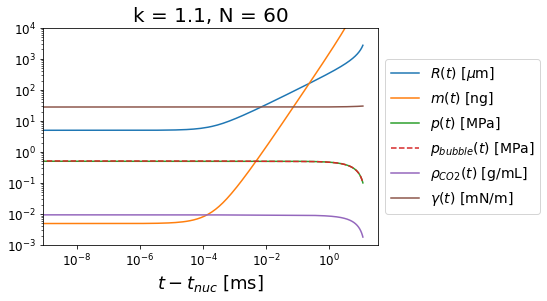

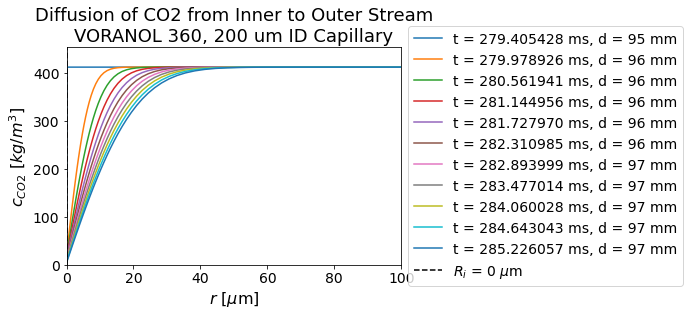

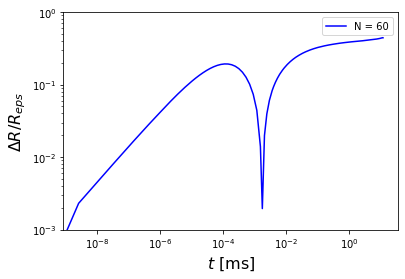

In [31]:
# plotting
props_list_log = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_log, x_log=True, title='k = {0:.1f}, N = {1:d}'.format(k, N))

reload(pltd)
n_plot = 10
r_arr = diffn.make_r_arr_log_res_end(N, R_max, end_pts, k=k)
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

# RADIUS ERROR
R_diff_list = []
label_list = []

R_eps = np.asarray(props_list_eps[0])
R_log = np.interp(t_eps, t_num, np.asarray(props_list_log[0]))
R_diff_list += [np.abs(R_eps - R_log) / R_eps]
label_list += ['N = {0:d}'.format(N)]

ax = pltd.diff(t_eps, R_diff_list, label_list)
ax.set_ylabel(r'$\Delta R/ R_{eps}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

### Effect of Adaptive Time Step Frequency

Vary the frequency with which the adaptive time step method is called.

In [7]:
reload(bubble)
reload(bubbleflow)
reload(an)
# fixed inputs
N_ = [8, 12, 15, 8, 12, 15]
dt_max_ = []
for N in N_:
    # computes smallest length scale in grid [m]
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]

    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]

grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform
# adapts time step after this many time steps
adapt_freq_ = [1, 1, 1, 10, 10, 10]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D]*len(adapt_freq_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'adapt_freq' : adapt_freq, 
                   'dt_max' : dt_max} for N, adapt_freq, dt_max in zip(N_, adapt_freq_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 1.793837 s.
Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 29.441260 s.
Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 330.813927 s.
Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 2.078462 s.
Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 21.519740 s.
Computing <function num_fix_D at 0x000001F5AC938950>
Computation time = 349.639602 s.


#### Plot Results

Text(0.5, 1.0, 'Compare Adaptive Time Step Frequency')

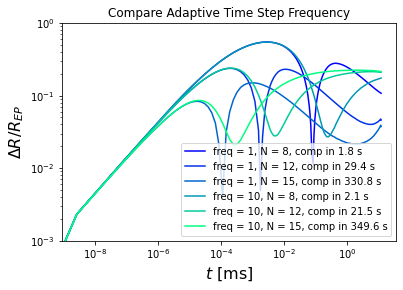

In [11]:
# creates labels
label_list = []
computation_times = [1.8, 29.4, 330.8, 2.08, 21.5, 349.6]

for adapt_freq, N, t in zip(adapt_freq_, N_, computation_times):
    label = 'freq = {0:d}, N = {1:d}, comp in {2:.1f} s'.format(adapt_freq, N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('Compare Adaptive Time Step Frequency')

Decreasing the frequency of adaptive time stepping reduced computation time a little bit and sometimes improved accuracy.

### Compare Legacy Adaptive Time Stepping to Intended Functionality

Previously, I was (unintentionally) performing adaptive time stepping by requiring that taking **one** time step of $dt$ and **one** time step of $2dt$ resulted in a radius with a fractional difference below a specified tolerance (which I call the *legacy mode*). This was a mistake. Now I am performing adaptive time stepping using the function `bubble.adaptive_time_step()` by requiring that taking **two** time steps of $dt$ and **one** time step of $2dt$ result in a radius with a fractional difference below the specified tolerance.

Because all calculations before January 9, 2021 used the legacy mode, I will demonstrate in the cell below that the difference in accuracy is negligible, but the difference in computation time may be significant.

In [45]:
reload(diffn)
# specifies legacy mode or not
legacy_mode_ = [True, True, False, False]
# specifies number of grid points
N_ = [8, 12, 8, 12]
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(legacy_mode_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
                      'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max,
                   'legacy_mode' : legacy_mode} for (N, legacy_mode, dt_max) 
                  in zip(N_, legacy_mode_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x000001412553AAE8>
Computation time = 22.591123 s.

Computing <function num_fix_D at 0x000001412553AAE8>
Computation time = 43.813247 s.

Computing <function num_fix_D at 0x000001412553AAE8>
Computation time = 1.362589 s.

Computing <function num_fix_D at 0x000001412553AAE8>
Computation time = 22.091908 s.



(0.001, 1)

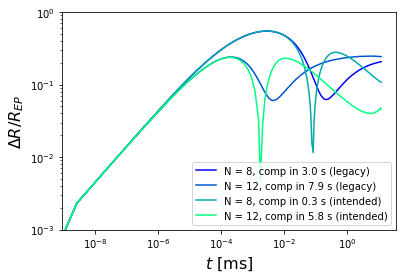

In [46]:
# creates labels
label_list = []
computation_times = [3.05, 7.89, 0.34, 5.78]

for legacy_mode, N, t in zip(legacy_mode_, N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(N, t)
    if legacy_mode:
        label += ' (legacy)'
    else:
        label += ' (intended)'
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

The intended implementation of adaptive time stepping is faster and more accurate.

### Vary k Parameter

The $k$ parameter is the ratio from one mesh element to the next in the direction of increasing radius. Below, we compare the effects of different values of $k$ on the speed and accuracy of computation. We look at $k \in [1,2]$, where 1 represents a uniform grid and 2 is a very extreme value limiting the maximum number of mesh elements and limiting accuracy.

In [35]:
reload(diffn)
reload(bubbleflow)
k_ = [1.0, 1.2, 1.4, 1.5, 1.6, 1.8, 2.0]
# specifies number of grid points
N = 8
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform
# computes smallest length scale in grid [m]
dt_max_ = []
for k in k_:
    r_arr_log = diffn.make_r_arr_log(N, R_max, k=k)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]
    
adapt_freq = 1
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(k_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'grid_params' : {'k' : k}, 'dcdt_fn' : dcdt_fn, 
                   'adapt_freq' : adapt_freq, 'dt_max' : dt_max} for k, dt_max in zip(k_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list, comp_time_list = an.compare_R(num_input_list, 
                                                                        num_fn_list, t_eps, R_eps, ret_comp_time=True)

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.286234 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.302192 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.300164 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.341088 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.437830 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 0.849761 s.

Computing <function num_fix_D at 0x00000196F692A0D0>
Computation time = 2.127314 s.



Text(0.5, 1.0, 'N = 8')

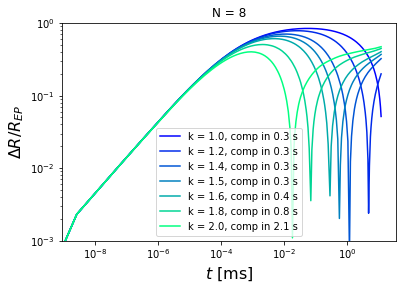

In [36]:
# creates labels
label_list = []

for k, t in zip(k_, comp_time_list):
    label = 'k = {0:.1f}, comp in {1:.1f} s'.format(k, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('N = {0:d}'.format(N))

### Vary Tolerance in Adaptive Time Stepping

Below, we vary the tolerance on the radius $R$ in the adaptive time stepping method to try to improve accuracy of the model.

In [41]:
reload(diffn)
reload(bubbleflow)
tol_R_ = [0.1, 0.01, 0.001, 0.0001, 1E-5, 1E-6]
# specifies number of grid points
N = 8
# computes smallest length scale in grid [m]

r_arr_log = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr_log[1] - r_arr_log[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max
    
adapt_freq = 10
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(tol_R_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'tol_R' : tol_R,
                   'adapt_freq' : adapt_freq, 'dt_max' : dt_max} for tol_R in tol_R_]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 1.074805 s.
Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 1.386705 s.
Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 1.093224 s.
Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 1.960849 s.
Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 4.733397 s.
Computing <function num_fix_D at 0x000002A4D91656A8>
Computation time = 12.846591 s.


Text(0.5, 1.0, 'N = 8')

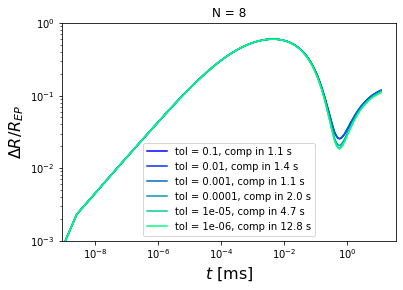

In [42]:
# creates labels
label_list = []

computation_times = [1.074805, 1.386705, 1.093224, 1.960849, 4.733397, 12.846591]

for tol_R, t in zip(tol_R_, computation_times):
    label = 'tol = {0:.1g}, comp in {1:.1f} s'.format(tol_R, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('N = {0:d}'.format(N))

### Vary alpha Parameter

The $\alpha$ parameter determines the rate at which the time step is increased with each call to `adaptive_time_step()`. Below, we vary it in the range $\alpha \in [0.1, 0.3]$.

In [43]:
reload(diffn)
reload(bubbleflow)
alpha_ = [1, 0.5, 0.3, 0.2, 0.1, 0.01]
# specifies number of grid points
N = 8
# computes smallest length scale in grid [m]
   
adapt_freq = 10
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(alpha_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'alpha' : alpha,
                   'adapt_freq' : adapt_freq, 'dt_max' : dt_max} for alpha in alpha_]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 1.018322 s.
Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 1.197460 s.
Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 1.206976 s.
Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 1.701561 s.
Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 2.831299 s.
Computing <function num_fix_D at 0x000002A4D9165378>
Computation time = 22.704845 s.


Text(0.5, 1.0, 'N = 8')

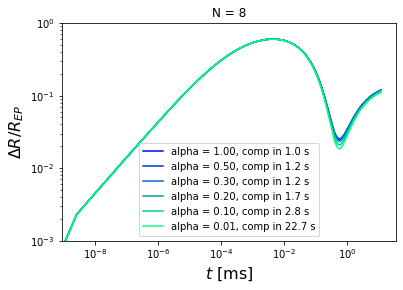

In [45]:
# creates labels
label_list = []

computation_times = [1.018322, 1.197460, 1.206976, 1.701561, 2.831299, 22.704845]

for alpha, t in zip(alpha_, computation_times):
    label = 'alpha = {0:.2f}, comp in {1:.1f} s'.format(alpha, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('N = {0:d}'.format(N))

### Test Fastest and Most Accurate Computation

In [13]:
reload(bubbleflow)
# specifies number of grid points
N_ = [8, 10, 12, 14, 16]

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x0000027C18B68950>
Computation time = 0.738539 s.
Computing <function num_fix_D at 0x0000027C18B68950>
Computation time = 2.579736 s.
Computing <function num_fix_D at 0x0000027C18B68950>
Computation time = 20.649018 s.
Computing <function num_fix_D at 0x0000027C18B68950>


KeyboardInterrupt: 

Text(0.5, 1.0, 'Effect of Grid Spacing for Fastest Parameters')

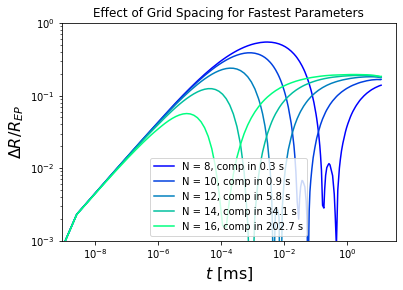

In [78]:
# creates labels
label_list = []

computation_times = [0.32, 0.94, 5.75, 34.08, 202.67]

for alpha, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(alpha, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Grid Spacing for Fastest Parameters')

#### Look at Effect of N on Concentration Gradient at Bubble Surface

In [88]:
reload(an)
reload(bubbleflow)
# specifies number of grid points
N_ = [8, 10, 12, 14]

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

dcdr_diff_list, dr_list_list, t_flow_list, raw_vals_list = an.compare_dcdr(num_input_list, num_fn_list, t_eps, dcdr_eps)

Computing <function num_fix_D at 0x000002A4DA4B8840>
Computation time = 0.310205 s.
Computing <function num_fix_D at 0x000002A4DA4B8840>
Computation time = 0.884669 s.
Computing <function num_fix_D at 0x000002A4DA4B8840>
Computation time = 5.737623 s.
Computing <function num_fix_D at 0x000002A4DA4B8840>
Computation time = 33.853129 s.


Text(0.5, 1.0, 'Effect of Grid Spacing for Fastest Parameters')

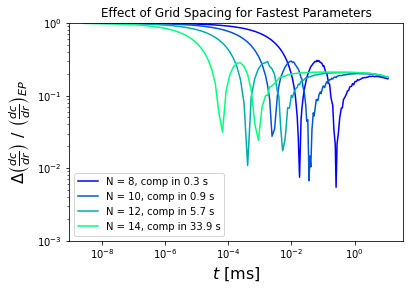

In [89]:
# creates labels
label_list = []

computation_times = [0.31, 0.88, 5.74, 33.9]

for alpha, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(alpha, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, dcdr_diff_list, label_list, None)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Grid Spacing for Fastest Parameters')

### Effect of N at Lower k?

In [40]:
reload(bubbleflow)
# specifies number of grid points
N_ = [8, 10, 12, 14]

dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform
k = 1.3
# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max, k=k)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'grid_params' : {'k' : k}, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list, comp_time_list = an.compare_R(num_input_list, num_fn_list,
                                                                        t_eps, R_eps, ret_comp_time=True)

Computing <function num_fix_D at 0x00000196DD9A1510>
Computation time = 0.304220 s.

Computing <function num_fix_D at 0x00000196DD9A1510>
Computation time = 0.328124 s.

Computing <function num_fix_D at 0x00000196DD9A1510>
Computation time = 0.439823 s.

Computing <function num_fix_D at 0x00000196DD9A1510>
Computation time = 0.757975 s.



Text(0.5, 1.0, 'Effect of N for k = 1.3')

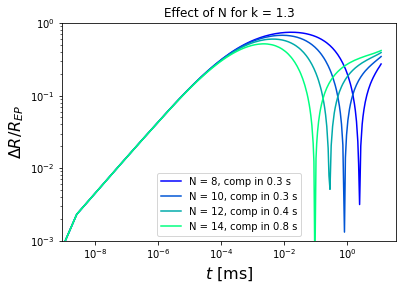

In [41]:
# creates labels
label_list = []

for N, t in zip(N_, comp_time_list):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of N for k = {0:.1f}'.format(k))

### Effect of k at Higher N?



In [11]:
reload(bubbleflow)
reload(diffn)
# specifies number of grid points
N_ = [8, 10, 12, 14, 16]
k = 1.6
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k, }} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x0000027C18B5A378>
Computation time = 0.994030 s.
Computing <function num_fix_D at 0x0000027C18B5A378>
Computation time = 3.116375 s.
Computing <function num_fix_D at 0x0000027C18B5A378>
Computation time = 21.587440 s.
Computing <function num_fix_D at 0x0000027C18B5A378>
Computation time = 121.972341 s.
Computing <function num_fix_D at 0x0000027C18B5A378>


KeyboardInterrupt: 

In [ ]:
# creates labels
label_list = []

computation_times = [0.30, 0.92, 5.62, 31.71, 195.79]

for alpha, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(alpha, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('k = {0:.1f}, add {1:d} end pts'.format(k, end_pts))

### Add More Points in the Bulk

Julie suggested on January 27, 2021, to improve accuracy at later times by increasing the number of points resolving the last mesh element. She believes that the last mesh element is being artificially fixed at the bulk value and that it's large size is restricting the propagation of the diffusion layer.

The cell below perform the same computations as the preceding cells, but add more points to resolve the last mesh element.

In [ ]:
reload(bubbleflow)
reload(diffn)
# specifies number of grid points
N_ = [8, 10, 12, 14, 16]
k = 1.6
end_pts = 8
grid_fn = diffn.make_r_arr_log_res_end
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'end_pts' : end_pts, 'k' : k, }} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

In [ ]:
# creates labels
label_list = []

computation_times = [0.30, 0.92, 5.62, 31.71, 195.79]

for alpha, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(alpha, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('k = {0:.1f}, add {1:d} end pts'.format(k, end_pts))

### Fix dr (smallest mesh spacing, at surface of bubble)

Instead of varying $k$ for fixed $N$ or varying $N$ for fixed $k$, I want to fix $d$, the parameter in `diffn.make_r_arr_log()` that roughly corresponds to the mesh size at the bubble surface ($r = 0$). I will fix this parameter $d$ and vary $N$, maintaining resolution at the bubble surface, but varying the resolution at larger $r$.

In [7]:
reload(bubbleflow)
reload(diffn)
# specifies number of grid points
N_ = [4, 6, 8, 10, 12]
dr = 1E-6 # [m], roughly the value for N = 8, k = 1.6, R = 100 um
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'dr' : dr}} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_fix_D at 0x0000027C18B5A488>
4.248772982142824


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:560: RuntimeWarning: invalid value encountered in double_scalars
  res1  = R - ( 3/(4*np.pi)*(m/f_rho_co2(p_bub)) )**(1/3.)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:683: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Computation time = 1.182308 s.
Computing <function num_fix_D at 0x0000027C18B5A488>
2.2343932284871584


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:684: RuntimeWarning: invalid value encountered in double_scalars
  R0 = (3/(4*np.pi)*m_prev/rho_co2_prev)**(1./3) #p[-1] + 2*if_tension[-1]/R0


Computation time = 2.409794 s.
Computing <function num_fix_D at 0x0000027C18B5A488>
1.7053572556589012
Computation time = 1.162083 s.
Computing <function num_fix_D at 0x0000027C18B5A488>
1.4739368134521458
Computation time = 4.214217 s.
Computing <function num_fix_D at 0x0000027C18B5A488>
1.347096914861071
Computation time = 20.870596 s.


Text(0.5, 1.0, 'Effect of $N$ for Fixed $dr$ = 1e-06')

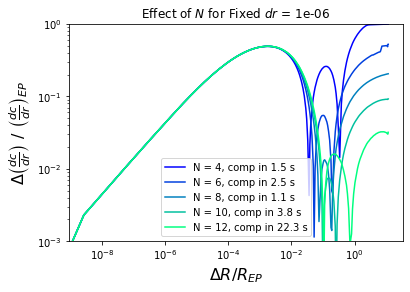

In [8]:
# creates labels
label_list = []

computation_times = [1.54, 2.46, 1.06, 3.80, 22.26]

for N, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of $N$ for Fixed $dr$' + ' = {0:g}'.format(dr))

Because the $dr$ at the bubble interface is fixed, the early-time error is unchanged with $N$, but the late-time error is reduced significantly by increasing the number of points (and thus, the resolution of the gradient at later times).

#### Reduce dr

I will reduce $dr$ to match the value at which the early-time error was kept low ($N = 16$, $k = 1.6$), which was 0.03 $\mu$m.

In [13]:
reload(bubbleflow)
reload(diffn)
# specifies number of grid points
N_ = [16, 32, 48, 60, 100]
dr = 0.03E-6 # [m], roughly the value for N = 16, k = 1.6, R = 100 um
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for N in N_:
    r_arr_log = diffn.make_r_arr_log(N, R_max, dr=dr)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(N_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'dr' : dr}} for (N, dt_max) 
                  in zip(N_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

1.609780303765338
1.2308721506627809
1.135948212450549
1.1020958025151666
1.0532044532441283
Computing <function num_fix_D at 0x0000028DE6E60D08>
1.609780303765338
Computation time = 259.853783 s.
Computing <function num_fix_D at 0x0000028DE6E60D08>
1.2308721506627809
Computation time = 254.239388 s.
Computing <function num_fix_D at 0x0000028DE6E60D08>
1.135948212450549
Computation time = 253.454443 s.
Computing <function num_fix_D at 0x0000028DE6E60D08>
1.1020958025151666
Computation time = 254.829171 s.
Computing <function num_fix_D at 0x0000028DE6E60D08>
1.0532044532441283
Computation time = 259.588591 s.


Text(0.5, 1.0, 'Effect of $N$ for Fixed $dr$ = 3e-08')

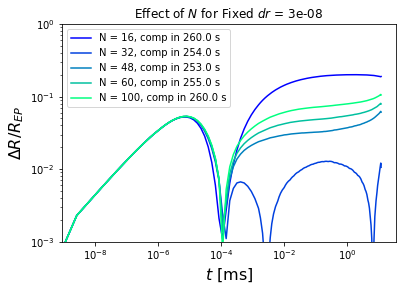

In [14]:
# creates labels
label_list = []

computation_times = [260, 254, 253, 255, 260]

for N, t in zip(N_, computation_times):
    label = 'N = {0:d}, comp in {1:.1f} s'.format(N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of $N$ for Fixed $dr$' + ' = {0:g}'.format(dr))

#### Reduce dr Further

In [11]:
reload(bubbleflow)
reload(diffn)
# specifies number of grid points
N = 32
dr_ = [1E-8, 3E-8, 1E-7] # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_fix_D_nonuniform

# computes smallest length scale in grid [m]
dt_max_ = []
for dr in dr_:
    r_arr_log = diffn.make_r_arr_log(N, R_max, dr=dr)
    d = r_arr_log[1] - r_arr_log[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max_ += [0.5*d**2/D_max]


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_fix_D] * len(dr_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'dr' : dr}} for (dr, dt_max) 
                  in zip(dr_, dt_max_)]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

1.2817834999336541
1.2308721506627809
1.175459456806985
Computing <function num_fix_D at 0x000002B085480D08>
1.2817834999336541
Computation time = 6671.803671 s.
Computing <function num_fix_D at 0x000002B085480D08>
1.2308721506627809
Computation time = 278.201242 s.
Computing <function num_fix_D at 0x000002B085480D08>
1.175459456806985
Computation time = 27.036859 s.


Text(0.5, 1.0, 'Effect of $dr$ for Fixed $N$ = 32')

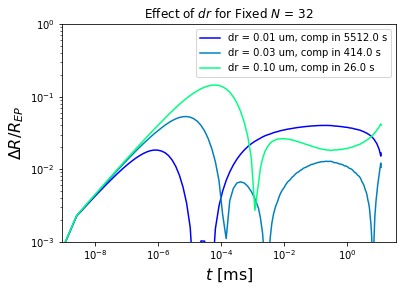

In [12]:
# creates labels
label_list = []

computation_times = [5512, 414, 26]

for dr, t in zip(dr_, computation_times):
    label = 'dr = {0:.2f} um, comp in {1:.1f} s'.format(dr*1E6, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of $dr$ for Fixed $N$' + ' = {0:d}'.format(N))

## Adaptive Meshing

Based on a discussion with Harsha Reddy on January 31, 2021, an effective way to perform adaptive meshing is the following:
    
    - Set a range of acceptable difference in values for an adjacent pair of mesh points to bear (low value and high value)
    - If the difference between the values of a pair of points exceeds the high threshold, compute evenly spaced values (concentrations) in between with a difference below the threshold and interpolate the corresponding grid points (r array) using a cubic spline (inverse function)
    - If the difference between the values (concentrations) of a pair of next-nearest neighbors is below the low threshold, remove the mutual neighbor in between them
    
You can then perform this remeshing periodically throughout the simulation to improve efficiency with minimal loss of error due to interpolation. At each remeshing, the maximum time step will also be updated based on the smallest mesh element.

In [6]:
%%time

reload(fd)
reload(bubble)
reload(diffn)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 32
end_pts = 1
D_max = 3E-8 # [m^2/s]
# thresholds on differences in concentration for remeshing [kg/m^3]
th_lo = 6
th_hi = 15

# computes smallest length scale in grid [m]
dr = 1E-7 # [m]
r_arr_log = diffn.make_r_arr_log(N, R_max, dr=dr)
dr_min = np.min(np.diff(r_arr_log))

# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*dr_min**2/D_max

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr_data = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max,
                                                             grid_fn=diffn.make_r_arr_log_res_end,
                                                             dcdt_fn=diffn.calc_dcdt_sph_fix_D_nonuniform,
                                                            grid_params={'end_pts' : end_pts, 'dr' : dr},
                                                            remesh_params={'th_lo' : th_lo, 'th_hi' : th_hi},
                                                               remesh_freq=500)

1.175459456806985
1.175459456806985
Wall time: 29.5 s


### Manual Remeshing

Based on discussion with JAK on February 10, 2021, we decided that we might maintain accuracy within 10% by remeshing from a $k=1.6$ to a $k=1.4$ grid after the diffusion boundary layer extends past the first grid point for the $k=1.6$ grid.

In [5]:
%%time

reload(fd)
reload(bubble)
reload(diffn)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 28
end_pts = 1
D_max = 3E-8 # [m^2/s]


# computes smallest length scale in grid [m]
remesh_fn = diffn.remesh_once_manual
k = 1.6
r_arr_log = diffn.make_r_arr_log(N, R_max, k=k)
dr_min = np.min(np.diff(r_arr_log))

# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*dr_min**2/D_max

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr_data = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max,
                                                             grid_fn=diffn.make_r_arr_log, adapt_freq=5,
                                                             dcdt_fn=diffn.calc_dcdt_sph_fix_D_nonuniform,
                                                            grid_params={'k' : k}, remesh_freq=100, remesh_fn=remesh_fn)

unstable
518.5943012652972
unstable
429.3508936747998
remeshed
t 3.999911513119514e-12
2.314046492888604e-09
1.1555601921603167e-10
remeshed
t 3.154152272699662e-09
8.461084648668168e-08
2.314046492888604e-09
Wall time: 2min 57s


(0.001, 1)

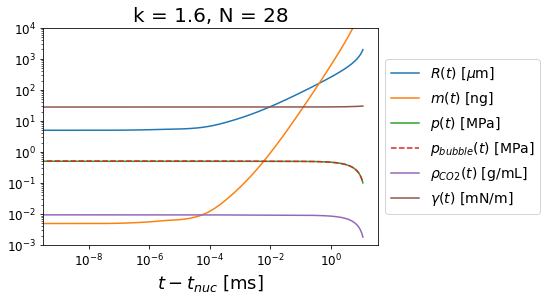

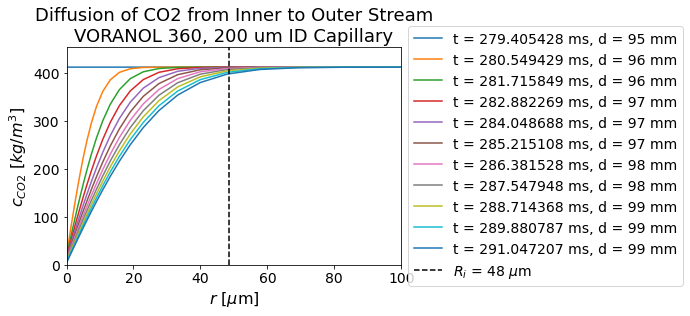

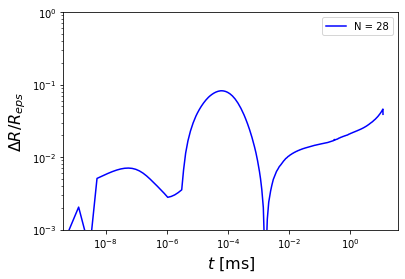

In [6]:
# plotting
props_list_log = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_log, x_log=True, title='k = {0:.1f}, N = {1:d}'.format(k, N))

reload(pltd)
# concentration profile
n_plot = 10
ax = pltd.sheath_remesh(t_flow, r_arr_data, c, R_i, R_max, v, c_bulk, n_plot)
pltg.legend(ax)

# RADIUS ERROR
R_diff_list = []
label_list = []

R_eps = np.asarray(props_list_eps[0])
R_log = np.interp(t_eps, t_num, np.asarray(props_list_log[0]))
R_diff_list += [np.abs(R_eps - R_log) / R_eps]
label_list += ['N = {0:d}'.format(N)]

ax = pltd.diff(t_eps, R_diff_list, label_list)
ax.set_ylabel(r'$\Delta R/ R_{eps}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])

Remeshing from k = 1.6 to k = 1.4 for N = 16 slightly reduces the error at the end, but the remeshing appears to happen too late to keep it below 10%, and the reduction is modest.

Solution: (1) remesh again later to k = 1.2; (2) earlier remeshing condition

### Compare Parameters for Adaptive Mesh

#### Vary Interpolation Scheme

We will start with the best-case example of adaptive meshing that keeps the errors below 10% and vary the interpolation scheme among `linear`, `quadratic`, and `cubic`.

In [7]:
reload(bubbleflow)
reload(diffn)

# varies parameters list 
interp_kind_ = ['linear', 'quadratic', 'cubic']

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D

# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max


# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(interp_kind_)
# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                   'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq, 
                   'remesh_params' : {'interp_kind' : interp_kind}} for interp_kind in interp_kind_]
                    

R_diff_list, dr_list_list, raw_vals_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps)

Computing <function num_vary_D at 0x00000223EBA2F158>
remeshed
2.314046492888604e-09
1.1555601921603167e-10
t 3.1251778942475994e-11 dt 2.5e-13 dt_max 8.924685285416749e-11
remeshed
8.461084648668168e-08
2.314046492888604e-09
t 1.008008065905841e-09 dt 4.751240943720205e-11 dt_max 1.1931658905321355e-07
t 0.28033211864455926 dt 9.575561980367849e-08 n_steps 10000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 20.20251396806234
t 0.2812896748427815 dt 9.575561980367849e-08 n_steps 20000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 18.768385544282662
t 0.28224723104100374 dt 9.575561980367849e-08 n_steps 30000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 17.33425712050306
t 0.283204787239226 dt 9.575561980367849e-08 n_steps 40000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 15.900128696723382
t 0.28416234343744823 dt 9.575561980367849e-08 n_steps 50000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 14.4660002729437
t 0.28511989963567047 

Text(0.5, 1.0, 'Effect of Interpolation Kind for Fixed $N$ = 28')

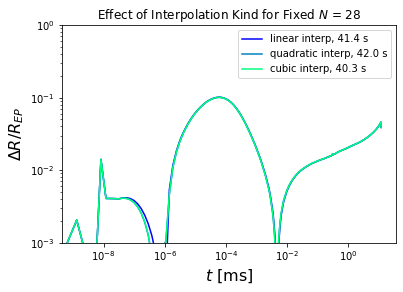

In [8]:
# creates labels
label_list = []

computation_times = [41.4, 42.0, 40.3]

for interp_kind, t in zip(interp_kind_, computation_times):
    label = '{0:s} interp, {1:.1f} s'.format(interp_kind, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Interpolation Kind for Fixed $N$' + ' = {0:d}'.format(N))

#### Vary Remeshing Index

In [9]:
reload(bubbleflow)
reload(diffn)
reload(an)

# varied parameters list 
i_remesh_ = [1, 2, 3, 5]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(i_remesh_)

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'quadratic'


# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max


# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                   'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq, 
                   'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' :i_remesh}} for i_remesh in i_remesh_]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

Computing <function num_vary_D at 0x00000223EBA2F0D0>
interpolation exceeded bulk value
remeshed
2.314046492888604e-09
1.1555601921603167e-10
t 3.1251778942475994e-11 dt 2.5e-13 dt_max 8.924685285416749e-11
interpolation exceeded bulk value
remeshed
8.461084648668168e-08
2.314046492888604e-09
t 1.008008065905841e-09 dt 4.751240943720205e-11 dt_max 1.1931658905321355e-07
t 0.28033211864455926 dt 9.575561980367849e-08 n_steps 10000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 20.20251396806234
t 0.2812896748427815 dt 9.575561980367849e-08 n_steps 20000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 18.768385544282662
t 0.28224723104100374 dt 9.575561980367849e-08 n_steps 30000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 17.33425712050306
t 0.283204787239226 dt 9.575561980367849e-08 n_steps 40000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 15.900128696723382
t 0.28416234343744823 dt 9.575561980367849e-08 n_steps 50000 dr 8.461084648668168e-08 c_

Text(0.5, 1.0, 'Effect of Remeshing Index for Fixed $N$ = 28')

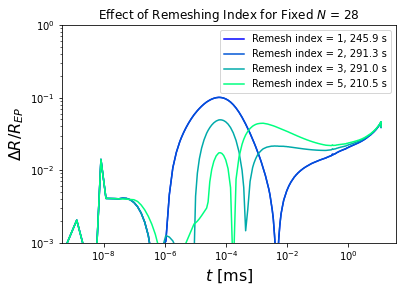

In [10]:
# creates labels
label_list = []

for i, t in zip(i_remesh_, comp_time_list):
    label = 'Remesh index = {0:d}, {1:.1f} s'.format(i, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Remeshing Index for Fixed $N$' + ' = {0:d}'.format(N))

#### Vary dk

In [11]:
reload(bubbleflow)
reload(diffn)
reload(an)

# varied parameters list 
dk_ = [0.05, 0.1, 0.2, 0.4]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(dk_)

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'quadratic'
i_remesh = 1


# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max


# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                   'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq, 
                   'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' : i_remesh, 'dk' : dk}} 
                  for dk in dk_]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

Computing <function num_vary_D at 0x00000223E59517B8>
interpolation exceeded bulk value
remeshed
1.6624353121572226e-10
1.1555601921603167e-10
t 3.1251778942475994e-11 dt 2.5e-13 dt_max 4.606151945178804e-13
interpolation exceeded bulk value
remeshed
2.607561124102395e-10
1.6624353121572226e-10
t 7.284145508990036e-11 dt 4.2250000000000007e-13 dt_max 1.1332291693216912e-12
interpolation exceeded bulk value
remeshed
4.4751620219537167e-10
2.607561124102395e-10
t 1.6219520171389945e-10 dt 9.282325000000002e-13 dt_max 3.33784585378948e-12
interpolation exceeded bulk value
remeshed
8.432803980621487e-10
4.4751620219537167e-10
t 4.098895112214507e-10 dt 2.651124843250001e-12 dt_max 1.1852030495930934e-11
interpolation exceeded bulk value
remeshed
1.7501505147415355e-09
8.432803980621487e-10
t 1.2967902862648373e-09 dt 9.84344096424823e-12 dt_max 5.105044707083438e-11
interpolation exceeded bulk value
remeshed
4.009639409533561e-09
1.7501505147415355e-09
t 5.401148917005827e-09 dt 4.75124094

t 0.2853826491278576 dt 1.1738631062747292e-08 n_steps 510000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 12.638352893536403
t 0.2855000354385294 dt 1.1738631062747292e-08 n_steps 520000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 12.462543844407346
t 0.28561742174920124 dt 1.1738631062747292e-08 n_steps 530000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 12.286734795278287
t 0.28573480805987306 dt 1.1738631062747292e-08 n_steps 540000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 12.11092574614923
t 0.2858521943705449 dt 1.1738631062747292e-08 n_steps 550000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 11.93511669702017
t 0.2859695806812167 dt 1.1738631062747292e-08 n_steps 560000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 11.759307647891113
t 0.2860869669918885 dt 1.1738631062747292e-08 n_steps 570000 dr 2.8256494800075625e-08 c_max 412.89699461065504 c_min 11.583498598762136
t 0.28620435330256033 dt 1.1738631

t 0.2833460480252963 dt 5.666013006134821e-08 n_steps 70000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 15.688562932912294
t 0.2839126493261739 dt 5.666013006134821e-08 n_steps 80000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 14.839966232219844
t 0.2844792506270515 dt 5.666013006134821e-08 n_steps 90000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 13.991369531527232
t 0.2850458519279291 dt 5.666013006134821e-08 n_steps 100000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 13.1427728308347
t 0.2856124532288067 dt 5.666013006134821e-08 n_steps 110000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 12.29417613014217
t 0.2861790545296843 dt 5.666013006134821e-08 n_steps 120000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 11.445579429449637
t 0.2867456558305619 dt 5.666013006134821e-08 n_steps 130000 dr 5.8681676491399585e-08 c_max 412.89699461065504 c_min 10.596982728757105
t 0.2873122571314395 dt 5.666013006134821e-08 n

Text(0.5, 1.0, 'Effect of k-reduction for Fixed $N$ = 28')

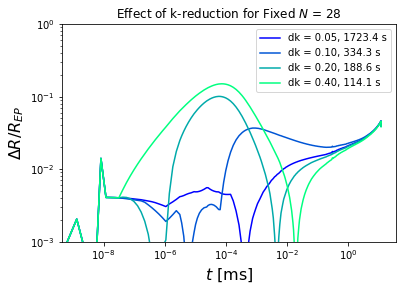

In [12]:
# creates labels
label_list = []

for dk, t in zip(dk_, comp_time_list):
    label = 'dk = {0:.2f}, {1:.1f} s'.format(dk, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of k-reduction for Fixed $N$' + ' = {0:d}'.format(N))

#### Vary Adaptive Time Step Frequency

In [13]:
reload(bubble)
reload(bubbleflow)
reload(diffn)
reload(an)

# varied parameters list 
adapt_freq_ = [1, 5, 10]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(adapt_freq_)

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'quadratic'
i_remesh = 1
dk = 0.2


# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max


# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn, 'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                   'adapt_freq' : adapt_freq, 'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq,
                   'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' : i_remesh, 'dk' : dk}} 
                  for adapt_freq in adapt_freq_]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

Computing <function num_vary_D at 0x00000223F98CF048>
interpolation exceeded bulk value
remeshed
2.314046492888604e-09
1.1555601921603167e-10
t 5.299882754883356e-11 dt 5e-13 dt_max 8.924685285416749e-11
interpolation exceeded bulk value
remeshed
8.461084648668168e-08
2.314046492888604e-09
t 6.2157637925608356e-09 dt 7.309601451877238e-11 dt_max 1.1931658905321355e-07
t 0.2803421282050924 dt 9.608340114723607e-08 n_steps 10000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 20.187522685778546
t 0.28130296221633566 dt 9.608340114723607e-08 n_steps 20000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 18.748485093398678
t 0.2822637962275789 dt 9.608340114723607e-08 n_steps 30000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 17.309447501018813
t 0.28322463023882216 dt 9.608340114723607e-08 n_steps 40000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 15.870409908638946
t 0.2841854642500654 dt 9.608340114723607e-08 n_steps 50000 dr 8.461084648668168e-08 c_

Text(0.5, 1.0, 'Effect of Adaptive Frequency for Fixed $N$ = 28')

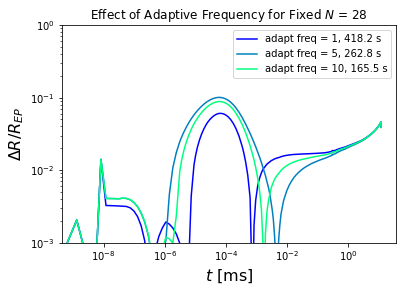

In [14]:
# creates labels
label_list = []

for adapt_freq, t in zip(adapt_freq_, comp_time_list):
    label = 'adapt freq = {0:d}, {1:.1f} s'.format(adapt_freq, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of Adaptive Frequency for Fixed $N$' + ' = {0:d}'.format(N))

#### Vary minimum k

In [15]:
reload(bubbleflow)
reload(diffn)
reload(an)

# varied parameters list 
k_min_ = [1.2, 1.0]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(k_min_)

# fixed parameters
N = 28
k = 1.6
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_once_manual
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'quadratic'
i_remesh = 1
dk = 0.2
adapt_freq = 5


# computes smallest length scale in grid [m]
r_arr = diffn.make_r_arr_log(N, R_max, k=k)
d = r_arr[1] - r_arr[0]
# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max


# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn,'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'k' : k},
                   'adapt_freq' : adapt_freq, 'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq,
                   'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' : i_remesh, 'dk' : dk, 'k_min' : k_min}} 
                  for k_min in k_min_]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

Computing <function num_vary_D at 0x00000223FBA3E268>
interpolation exceeded bulk value
remeshed
2.314046492888604e-09
1.1555601921603167e-10
t 3.1251778942475994e-11 dt 2.5e-13 dt_max 8.924685285416749e-11
interpolation exceeded bulk value
remeshed
8.461084648668168e-08
2.314046492888604e-09
t 1.008008065905841e-09 dt 4.751240943720205e-11 dt_max 1.1931658905321355e-07
t 0.28033211864455926 dt 9.575561980367849e-08 n_steps 10000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 20.20251396806234
t 0.2812896748427815 dt 9.575561980367849e-08 n_steps 20000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 18.768385544282662
t 0.28224723104100374 dt 9.575561980367849e-08 n_steps 30000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 17.33425712050306
t 0.283204787239226 dt 9.575561980367849e-08 n_steps 40000 dr 8.461084648668168e-08 c_max 412.89699461065504 c_min 15.900128696723382
t 0.28416234343744823 dt 9.575561980367849e-08 n_steps 50000 dr 8.461084648668168e-08 c_

Text(0.5, 1.0, 'Effect of min k')

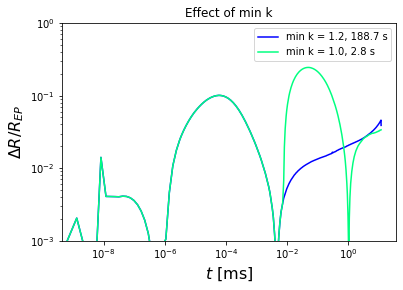

In [16]:
# creates labels
label_list = []

for k_min, t in zip(k_min_, comp_time_list):
    label = 'min k = {0:.1f}, {1:.1f} s'.format(k_min, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of min k')

### Vary N

In [17]:
reload(bubble)
reload(bubbleflow)
reload(diffn)
reload(an)

D_max = 3E-8

# varied parameters list 
N_ = [25, 50, 100]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)


# fixed parameters
dr = 1E-9
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_dr
remesh_freq = 100 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'quadratic'
i_remesh = 10
adapt_freq = 5
dr_max = 5E-7

dt_max_ = []
for N in N_:
    # computes smallest length scale in grid [m]
    r_arr = diffn.make_r_arr_log(N, R_max, dr=dr)
    d = r_arr[1] - r_arr[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max = 0.5*d**2/D_max
    dt_max_ += [dt_max]

dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file = eps_params

dt = 1E-15
eps_params = dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file

# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn,'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'dr' : dr},
                   'adapt_freq' : adapt_freq, 'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq,
                   'remesh_params' : {'interp_kind' : interp_kind, 'i_remesh' : i_remesh, 'dr_max' : R_max/N}} 
                  for N, dt_max in zip(N_, dt_max_)]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

1.5471184766493469
1.2215455080493576
1.0960359252617093
Computing <function num_vary_D at 0x00000223FBA3E2F0>
1.5471184766493469
t 0.27940558929810116 dt 1.6440084118549477e-11 n_steps 10000 dr 1e-09 c_max 412.89699461065504 c_min 21.5901735891775
t 0.27940575369881643 dt 1.6440084118549477e-11 n_steps 20000 dr 1e-09 c_max 412.89699461065504 c_min 21.589927366826167
t 0.2794059180995317 dt 1.6440084118549477e-11 n_steps 30000 dr 1e-09 c_max 412.89699461065504 c_min 21.589681144474834
1.4730856749307482
interpolation exceeded bulk value
remeshed
2e-09
1e-09
t 5.660426057874091e-07 dt 1.6440084118549477e-11 dt_max 6.666666666666668e-11
t 0.2794063228296207 dt 6.104088152628591e-11 n_steps 40000 dr 2e-09 c_max 412.89699461065504 c_min 21.589074981697454
1.4075004617308104
interpolation exceeded bulk value
remeshed
4e-09
2e-09
t 1.120910473995096e-06 dt 6.104088152628591e-11 dt_max 2.6666666666666673e-10
1.3489357021741046
interpolation exceeded bulk value
remeshed
8e-09
4e-09
t 2.3651898

Text(0.5, 1.0, 'Effect of N')

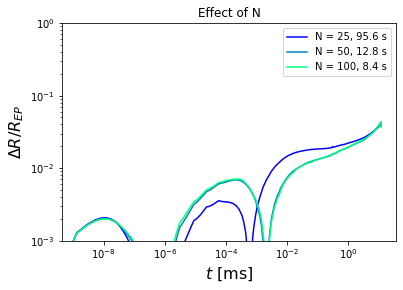

In [18]:
# creates labels
label_list = []

for N, t in zip(N_, comp_time_list):
    label = 'N = {0:d}, {1:.1f} s'.format(N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of N')

Increasing $N$ doesn't seem to affect the late-time error. Not sure why...

### Remeshing According to Curvature

In [5]:
reload(bubble)
reload(bubbleflow)
reload(diffn)
reload(an)

D_max = 3E-8

# varied parameters list 
N_ = [28, 36, 50, 100]
# collects bubble-growth functions
num_fn_list = [bubbleflow.num_vary_D] * len(N_)


# fixed parameters
dr = 1E-9
R_max = 100E-6 # [m]
grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_curv
remesh_freq = 1000 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'linear'
adapt_freq = 5

dt_max_ = []
for N in N_:
    # computes smallest length scale in grid [m]
    r_arr = diffn.make_r_arr_log(N, R_max, dr=dr)
    d = r_arr[1] - r_arr[0]
    # defines smallest time step to remain below smallest diffusion time scale
    dt_max = 0.5*d**2/D_max
    dt_max_ += [dt_max]

dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file = eps_params

dt = 1E-15
eps_params = dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file

# groups inputs for each function
num_input_list = [{'t_nuc' : t_nuc, 'eps_params' : eps_params, 'R_max' : R_max, 'N' : N, 'D_fn' : D_fn,
          'grid_fn' : grid_fn,'dcdt_fn' : dcdt_fn, 'dt_max' : dt_max, 'grid_params' : {'dr' : dr},
                   'adapt_freq' : adapt_freq, 'remesh_fn' : remesh_fn, 'remesh_freq' : remesh_freq,
                   'remesh_params' : {'interp_kind' : interp_kind}} 
                  for N, dt_max in zip(N_, dt_max_)]
                    

R_diff_list, _, _, comp_time_list = an.compare_R(num_input_list, num_fn_list, t_eps, R_eps, ret_comp_time=True)

1.4682618012925237
1.335742543998549
1.2215455080493576
1.0960359252617093
Computing <function num_vary_D at 0x000001599561F1E0>
1.4682618012925237
remeshed
t 1.3656202502154713e-08 dt 1.6440084118549477e-11 dt_max 1.1647505135541486e-05
remeshed
t 0.007670083124177607 dt 1.1064420328796789e-05 dt_max 0.0001123825170497365
Computation time = 1.020279 s.

Computing <function num_vary_D at 0x000001599561F1E0>
1.335742543998549
remeshed
t 1.3656202502154713e-08 dt 1.6440084118549477e-11 dt_max 6.642213835845546e-06
remeshed
t 0.004289808409636053 dt 5.9599401705913045e-06 dt_max 4.9171276483929685e-05
Computation time = 1.053172 s.

Computing <function num_vary_D at 0x000001599561F1E0>
1.2215455080493576
remeshed
t 1.3656202502154713e-08 dt 1.6440084118549477e-11 dt_max 2.929198380457053e-06
remeshed
t 0.0018623549399278128 dt 2.469515645052996e-06 dt_max 1.5086888355119905e-05
Computation time = 1.358371 s.

Computing <function num_vary_D at 0x000001599561F1E0>
1.0960359252617093
remeshe

Text(0.5, 1.0, 'Effect of N')

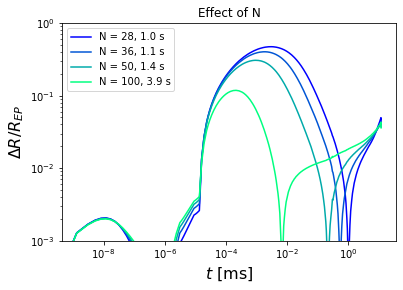

In [6]:
# creates labels
label_list = []

for N, t in zip(N_, comp_time_list):
    label = 'N = {0:d}, {1:.1f} s'.format(N, t)
    label_list += [label]
    
    
ax = pltd.diff(t_eps, R_diff_list, label_list, None)
ax.set_ylabel(r'$\Delta R/R_{EP}$', fontsize=16)
ax.set_ylim([1E-3, 1])
ax.set_title('Effect of N')

In [19]:
%%time

reload(bubble)
reload(diffn)
reload(bubbleflow)

# simulation parameters
R_max = 100E-6
N = 400
D_max = 3E-8 # [m^2/s]

# fixed parameters
dr = 1E-9
# computes smallest length scale in grid [m]
r_arr_log = diffn.make_r_arr_log(N, R_max, dr=dr)
d = r_arr_log[1] - r_arr_log[0]

# defines smallest time step to remain below smallest diffusion time scale
dt_max = 0.5*d**2/D_max

grid_fn = diffn.make_r_arr_log
dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
remesh_fn = diffn.remesh_curv
remesh_freq = 1000 # heuristic
D_fn = diffn.fixed_D
interp_kind = 'linear'
adapt_freq = 5

dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file = eps_params

dt = 1E-15
eps_params = dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file


# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, dr_list = bubbleflow.num_vary_D(t_nuc, eps_params, R_max, N, dt_max=dt_max,
                                                             grid_fn=grid_fn, dcdt_fn=dcdt_fn, D_fn=D_fn,
                                                            grid_params={'dr' : dr}, adapt_freq=adapt_freq,
                                                            remesh_fn=remesh_fn, remesh_freq=remesh_freq,
                                                            remesh_params={'interp_kind' : interp_kind})

1.0190630377815153
1.0190630377815153
remeshed
t 1.3656202502154713e-08 dt 1.6440084118549477e-11 dt_max 7.65851891337147e-10
remeshed
t 6.28690565607215e-07 dt 6.473079898728664e-10 dt_max 1.12056022944161e-07
remeshed
t 8.821232367955956e-05 dt 9.463126845172879e-08 dt_max 8.077596094780379e-07
remeshed
t 0.000843268836863309 dt 7.719363284327332e-07 dt_max 1.0416666666699926e-06
remeshed
t 0.0018465544829476266 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
remeshed
t 0.002850071709930513 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
remeshed
t 0.003853588936913399 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
remeshed
t 0.004857106163896285 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
remeshed
t 0.005860623390879172 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
remeshed
t 0.006864140617862058 dt 1.0035172269625532e-06 dt_max 1.0416666666699926e-06
t 0.2862715753006908 dt 1.0035172269625532e-06 n_steps 10000 dr 2.500000000004029e-07 

1.0190630377815153


(0.001, 1)

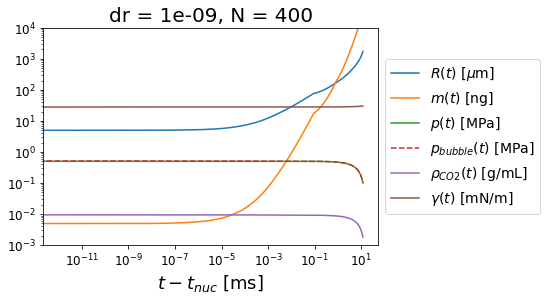

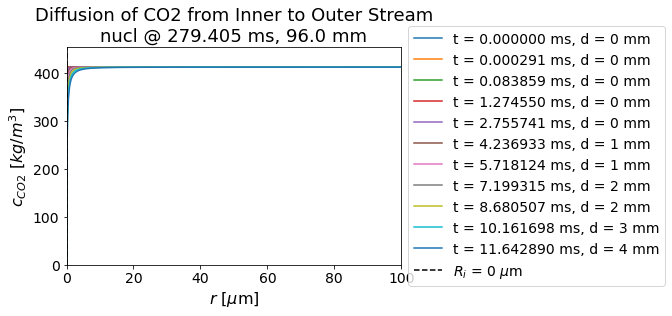

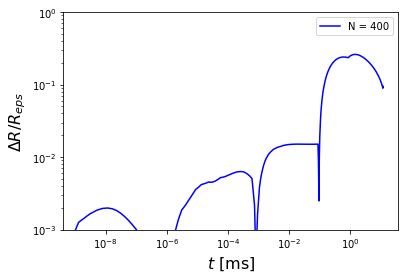

In [20]:
# plotting
props_list_log = (R, m, p, p_bub, rho_co2, if_tension)
ax = pltb.all_props(t_num, t_nuc, props_list_log, x_log=True, title='dr = {0:g}, N = {1:d}'.format(dr, N))

reload(pltd)
n_plot = 10
r_arr = diffn.make_r_arr_log(N, R_max, dr=dr)
ax = pltd.sheath(t_flow, r_arr, c, 0, R_max, v, c_bulk, n_plot)

# plots legend outside box
pltg.legend(ax)

# RADIUS ERROR
R_diff_list = []
label_list = []

R_eps = np.asarray(props_list_eps[0])
R_log = np.interp(t_eps, t_num, np.asarray(props_list_log[0]))
R_diff_list += [np.abs(R_eps - R_log) / R_eps]
label_list += ['N = {0:d}'.format(N)]

ax = pltd.diff(t_eps, R_diff_list, label_list)
ax.set_ylabel(r'$\Delta R/ R_{eps}$', fontsize=ax_fs)
ax.set_ylim([1E-3, 1])